In [1]:
%matplotlib inline

In [2]:
import redqueen.opt_model as OM
import redqueen.opt_runs as OR
import redqueen.utils as RU
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import decorated_options as Deco
import multiprocessing as MP

In [3]:
sns.set_style(style='dark')
sns.set_palette('Set2')

In [4]:
from importlib import reload
reload(OM)
reload(OR)
reload(RU)

<module 'redqueen.utils' from '/NL/stackexchange/work/prog/broadcast-online/redqueen/utils.py'>

In [5]:
OR.SimOpts(**{
        'src_id': 1,
        'q_vec': [],
        's': 1.0,
        'other_sources': [
            (
                'Poisson', 
                {
                    'src_id': 2,
                    'seed': 42,
                    'rates': 100
                }
            )
        ],
        'sink_ids': [1001],
        'end_time': 100.0,
        'edge_list': [(1, 1001), (2, 1001)]
    })

In [6]:
simOpts = OR.SimOpts.std_poisson(42, 1000)

# Exponential sampler

The output intensity is given by:

$$
u(t) = \exp( \underbrace{W_h \cdot h_j}_{\text{past}} + \overbrace{W_t (t - t_j)}^{\text{decay}} + \underbrace{b_t}_{\text{base}} )
$$

where $t_j$ is the last event before $t$.

It is simplified to the following in the code:

$$
u(t) = c \cdot e^{W_t \cdot (t - t_j)}
$$

In [7]:
%run -i tpprl/exp_sampler.py

Testing the sampler.

In [8]:
def_plot_opts = Deco.Options(vt=0.5, 
                             wt=-1.0,
                             bt=1.0,
                             init_h=0,
                             t_min=0,
                             t_max=10,
                             resolution=200)

@Deco.optioned()
def plot_lambda(vt, wt, bt, init_h, t_min, t_max, events, resolution):
    X = np.linspace(t_min, t_max, num=resolution)
    
    
    event_idx = 0
    c = np.exp(vt * init_h + bt)
    t0 = t_min
    
    # TODO: In the baseilne, shouldn't the t_0 still be updated to the latest event?
    Y1 = [c * np.exp(wt * (x - t0)) for x in X]
    
    Y2 = [None] * len(X)
    for idx, x in enumerate(X):
        while event_idx < len(events) and events[event_idx][0] < x:
            c = np.exp(vt * events[event_idx][1] + bt)
            t0 = events[event_idx][0]
            event_idx += 1
            
        Y2[idx] = c * np.exp(wt * (x - t0))
    
    plt.step(X, Y1, '--', label='Baseline')
    plt.step(X, Y2, '-', label='Correct')
    plt.vlines([x[0] for x in events], ymin=0, ymax=max(Y2), label='Events')
    plt.legend()
    return (X, Y1, Y2)

In [9]:
events = [(1, -8), (5, 5), (9, 0)]

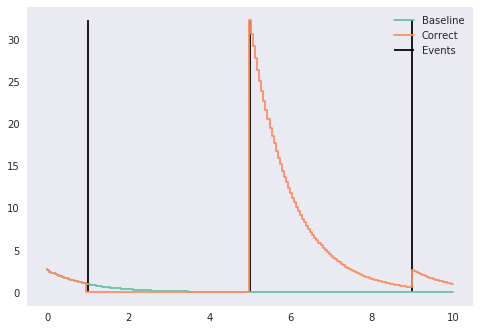

In [10]:
X, Y1, Y2 = plot_lambda(events=events, _opts=def_plot_opts)

In [11]:
sampler = ExpCDFSampler(_opts=def_plot_opts, seed=101 + 1279)

In [12]:
sampler.generate_sample()

0.6092880541958573

In [13]:
sampler.reset_only_sample(sampler.generate_sample())

0.98369540000156641

In [14]:
sampler.reset(1, -4, False)

0.9725887021550208

In [15]:
sampler.register_event(5, 0.5, False)

4.924794439657469

In [16]:
sampler.reset_only_sample(sampler.generate_sample())

4.9482122321618336

In [17]:
sampler.register_event(9, 0, False)

8.7893001591946209

In [18]:
sampler.reset_only_sample(sampler.generate_sample())

9.0386156318159898

In [19]:
sampler.generate_sample()

9.0386156318159898

## Tests

In [15]:
%%time
all_sim_events = []
processes = None
N = 10000
verbose = False

assert not verbose or (N < 10 and processes is not None), "Cannot have verbose output with these settings."

def worker_sampler(params):
    ii, sampler = params
    event_idx = 0
    next_sample = sampler.generate_sample()
    sim_events = []
        
    while next_sample < def_plot_opts.t_max or event_idx < len(events):
        while event_idx < len(events) and \
              events[event_idx][0] < next_sample:
            # print("Old = ", next_sample)
            old_sample = next_sample
            next_sample = sampler.register_event(events[event_idx][0], 
                                                 events[event_idx][1], 
                                                 False)
            if verbose:
                print("Eps = {}, Old = {}, Event = {}, Next = {}"
                      .format(ii, old_sample, events[event_idx], next_sample))
                
            event_idx += 1
            
        if next_sample > def_plot_opts.t_max:
            break
            
        if verbose:
            print("Final sample = {}".format(next_sample))                
        
        sim_events.append(next_sample)
        next_sample = sampler.reset_only_sample(next_sample)
    
    return sim_events
    

with MP.Pool(processes=processes) as pool:
    for sim_events in pool.map(worker_sampler,
                               [(ii, ExpCDFSampler(_opts=def_plot_opts, seed=101 + ii))
                                for ii in range(N)]):
        all_sim_events.append(sim_events)


CPU times: user 1.44 s, sys: 693 ms, total: 2.14 s
Wall time: 2.21 s


In [16]:
flat_events = [x for y in all_sim_events for x in y]

In [17]:
[x for x in flat_events if x < 0]

[]

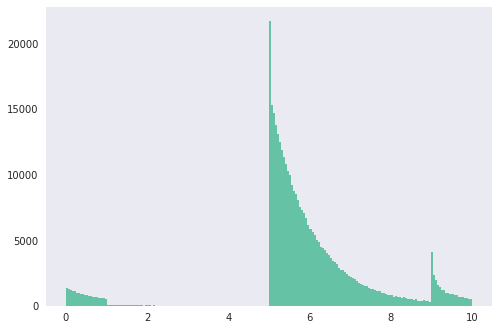

In [18]:
plt.hist(flat_events, bins=200);

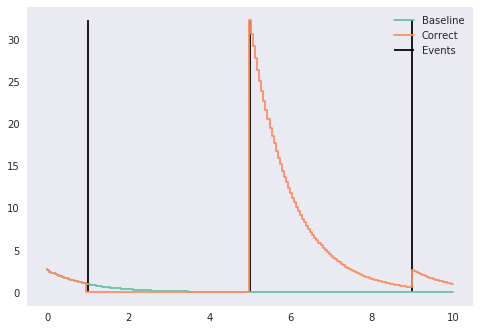

In [19]:
X, Y1, Y2 = plot_lambda(events=events, _opts=def_plot_opts)

In [20]:
len(all_sim_events)

10000

## ExpCDFBroadcaster

In [21]:
class ExpBroadcasterOld(OM.Broadcaster):
    
    @Deco.optioned()
    def __init__(self, src_id, seed, vt, wt, bt, init_h, t_min=0):
        super(ExpBroadcasterOld, self).__init__(src_id, seed)
        self.init = False
        self.vt = vt
        self.wt = wt
        self.bt = bt
        self.init_h = init_h
        self.exp_sampler = ExpCDFSampler(vt=vt, wt=wt, bt=bt,
                                         init_h=init_h, t_min=t_min, seed=seed)
        
    def get_next_interval(self, event):
        if not self.init:
            self.init = True
            # Nothing special to do for the first event.
            
        self.state.apply_event(event)
        
        if event is None:
            # This is the first event. Post immediately to join the party?
            # Or hold off?
            return self.exp_sampler.generate_sample()
        elif event.src_id == self.src_id:
            # We posted.
            hidden_state = self.exp_sampler.get_last_hidden_state()
            new_hidden_state = self.random_state.randn(*hidden_state.shape)
            self.exp_sampler.register_event(time=self.get_current_time(event), 
                                            new_h=hidden_state,
                                            own_event=True)
        else:
            # Have to update the hidden state and the t0 of our ExpSampler
            return None # Preserve the old time

In [22]:
OM.SimOpts.registerSource('ExpBroadcasterOld', ExpBroadcasterOld)

In [23]:
RS = np.random.RandomState(420)

simOpts = OM.SimOpts(
   src_id = 1,
   end_time = 100, # When the simulations stop
   q_vec = np.asarray([1.0, 1.0]), # Weights of followers
   s = 1.0, # Control parameter for RedQueen
   sink_ids = [1, 2],
   other_sources = [
      ('ExpBroadcasterOld', 
       {'src_id': 2,
        'seed': 42,
        'wt': 0.5,
        'init_h': 0.1 * RS.randn(10),
        'vt': 0.1 * RS.randn(10),
        'bt': 1.0,
       }
      ),
      ('Hawkes',
       {'src_id': 3,
        'seed': 43,
        'alpha': 0.01 * np.exp(RS.randn(10).dot(RS.randn(10))),
        'beta': 0.5,
        'l_0': np.exp(1.0)
       }
      )
   ],
   edge_list=[(1, 1), (1, 2), 
              (2, 1), (2, 2),
              (3, 1), (3, 2)]
)

In [30]:
mgr = simOpts.create_manager_with_opt(seed=6)

In [31]:
%%time
mgr.run_dynamic()

CPU times: user 153 ms, sys: 3.33 ms, total: 157 ms
Wall time: 150 ms


In [32]:
df = mgr.get_state().get_dataframe()

In [33]:
df.head()

,event_id,sink_id,src_id,t,time_delta
0,100,1,1,0.000000,0.000000
1,100,2,1,0.000000,0.000000
2,101,1,3,0.044966,0.044966
3,101,2,3,0.044966,0.044966
4,102,1,3,0.097634,0.052668


In [34]:
df.groupby('src_id').size()

src_id
1     614
2    1174
3     520
dtype: int64

# Reinf broadcaster

In [34]:
# iterSession = tf.InteractiveSession()

In [35]:
# iterSession.run(tf.one_hot([0,1], depth=1, dtype=tf.float32))

In [36]:
# input_dim = 1
# hidden_dim = 16

# class ReinfNetwork():
#     def __init__(self, s_size, scope, trainer):
#         with tf.variable_scope(scope):
#             self.event_source = tf.placeholder(dtype=tf.int64, name='Event source', shape=[1])
#             self.inp = tf.one_hot(indices=[self.event_source], depth=1, dtype=tf.float32)
#             self.cell = tf.contrib.rnn.BasicRNNCell(hidden_dim)
#             self.Wh = tf.get_variable('Wh', shape=)            

In [37]:
# class Reinf(OM.Broadcaster):
    
#     @Deco.optioned()
#     def __init__(self, src_id, seed, hidden_dim):
#         super(Reinf, self).__init__(src_id, seed)
#         self.init = False
        
#         self.Wh = tf.get_variable()
        
#     def get_next_interval(self, event):
#         if not self.init:
#             # Create variables here?
#             self.init = True
        
#         self.state.apply_event(event)
        
#         if event is None:
#             # This is the first event. Post immediately to join the party?
#             # Or hold off?
#             return np.inf
        
#         elif event.src_id == self.src_id:
#             # We posted. Calculate reward.
#             # We would never like to post now.
#             return np.inf
        
#         else:
#             # Update our rate of posting.
#             r_t = self.state.get_wall_rank(self.src_id, self.sink_ids,
#                                            dict_form=False)
#             # TODO: Magic.
#             #  1 - Reward for this interval?
#             #  2 - Sample the posting time again using inverse CDF
#             #  3 - New sample is guaranteed to be closer to now than
#             #      the original posting time.
#             cur_time = event.cur_time
#             t_delta_new = 10 # TODO: Take a new sample here.
#             return cur_time + t_delta_new - self.last_self_event_time
        
#     def train(self):
#         """Will do RL here."""
#         pass
            


In [38]:
# mgr = simOpts.create_manager_with_broadcaster(Reinf(1, 100))

In [39]:
# mgr.run_dynamic()

In [40]:
# df = mgr.state.get_dataframe()

In [41]:
# df.head()

# ExpTrainer

In [42]:
%run -i tpprl/exp_broadcaster.py
%run -i tpprl/exp_sampler.py

In [43]:
# reload(exp_sampler)

In [44]:
tf.reset_default_graph()

In [26]:
iterSession.close()

NameError: name 'iterSession' is not defined

In [45]:
iterSession = tf.Session()

In [28]:
%%time
hidden_dims = 10
num_other_broadcasters = 1
RS = np.random.RandomState(seed=42)

trainer_opts = Deco.Options(
    Wh=RS.randn(hidden_dims, hidden_dims) * 0.1 + np.diag(np.ones(hidden_dims)), # Careful initialization
    Wm=RS.randn(num_other_broadcasters + 1, hidden_dims),
    Wr=RS.randn(hidden_dims, 1),
    Wt=RS.randn(hidden_dims, 1),
    Bh=RS.randn(hidden_dims, 1),
    
    vt=RS.randn(hidden_dims, 1),
    wt= -1 * np.abs(RS.rand(1)),
    bt=np.abs(RS.randn(1)),
    
    init_h=RS.randn(hidden_dims),
    
    max_events=50,
    batch_size=16,
    
    learning_rate=.01,
    clip_norm=1.0
)
sim_opts = OM.SimOpts(
    sink_ids=[1000],
    src_id=1,
    other_sources=[('Hawkes', {'src_id': 100, 'seed': 93})],
    end_time=100.0,
    q_vec=None,
    s=1.0,
    edge_list=None
)

trainer = ExpRecurrentTrainer(sim_opts=sim_opts, _opts=trainer_opts, sess=iterSession)

CPU times: user 18min 36s, sys: 1min 50s, total: 20min 27s
Wall time: 18min 50s


In [29]:
%%time
trainer.initialize(finalize=False)

CPU times: user 2min 18s, sys: 13.6 s, total: 2min 32s
Wall time: 2min 21s


In [162]:
# trainer.restore(epoch_to_recover=1)

INFO:tensorflow:Restoring parameters from tpprl-log/tpprl.ckpt-1


In [30]:
iterSession.run([trainer.tf_wt, trainer.tf_bt])

[array([-0.71217924], dtype=float32), array([ 0.7511794], dtype=float32)]

In [11]:
iterSession.run([trainer.tf_wt, trainer.tf_bt])

[array([-0.71217924], dtype=float32), array([ 0.7511794], dtype=float32)]

In [31]:
%%time
trainer.train_many(100)

[2018-02-22T14:50:11] Run 0, LL -247.556, loss 90.538, r^2(t) 19630.652, CTG 19721.191, seeds 42--57, grad_norm 2927765.500
[2018-02-22T14:51:30] Run 1, LL -258.703, loss 56.753, r^2(t) 18935.678, CTG 18992.430, seeds 58--73, grad_norm 2857852.000
[2018-02-22T14:52:41] Run 2, LL -262.570, loss 51.390, r^2(t) 20569.812, CTG 20621.203, seeds 74--89, grad_norm 3085788.000
[2018-02-22T14:53:52] Run 3, LL -269.341, loss 46.575, r^2(t) 19957.938, CTG 20004.514, seeds 90--105, grad_norm 3009411.750
[2018-02-22T14:55:03] Run 4, LL -275.382, loss 29.797, r^2(t) 20409.555, CTG 20439.352, seeds 106--121, grad_norm 3093509.000
[2018-02-22T14:56:12] Run 5, LL -280.476, loss 32.520, r^2(t) 19965.473, CTG 19997.992, seeds 122--137, grad_norm 3000724.000
[2018-02-22T14:57:20] Run 6, LL -288.407, loss 33.282, r^2(t) 22931.113, CTG 22964.395, seeds 138--153, grad_norm 3484569.500
[2018-02-22T14:58:29] Run 7, LL -293.404, loss 32.861, r^2(t) 21852.051, CTG 21884.912, seeds 154--169, grad_norm 3301474.500

[2018-02-22T15:57:01] Run 58, LL -137.605, loss 421559616.000, r^2(t) 0.000, CTG 421559616.000, seeds 970--985, grad_norm 192162414592.000
[2018-02-22T15:58:08] Run 59, LL -143.465, loss 534835584.000, r^2(t) 0.000, CTG 534835584.000, seeds 986--1001, grad_norm 258384674816.000
[2018-02-22T15:59:17] Run 60, LL -153.255, loss 483925536.000, r^2(t) 0.000, CTG 483925536.000, seeds 1002--1017, grad_norm 260591878144.000
[2018-02-22T16:00:25] Run 61, LL -212.871, loss 765105536.000, r^2(t) 0.000, CTG 765105536.000, seeds 1018--1033, grad_norm 563864338432.000
[2018-02-22T16:01:33] Run 62, LL -240.808, loss 764470784.000, r^2(t) 0.000, CTG 764470784.000, seeds 1034--1049, grad_norm 613557665792.000
[2018-02-22T16:02:41] Run 63, LL -227.261, loss 785328768.000, r^2(t) 0.000, CTG 785328768.000, seeds 1050--1065, grad_norm 664778440704.000
[2018-02-22T16:03:49] Run 64, LL -301.840, loss 893326400.000, r^2(t) 0.000, CTG 893326400.000, seeds 1066--1081, grad_norm 972768673792.000
[2018-02-22T16:0

In [37]:
%%time
init_seed = 426
dfs = [trainer.run_sim(seed) for seed in range(init_seed, init_seed + trainer.batch_size)]
f_d = trainer.get_feed_dict(dfs)

CPU times: user 4.3 s, sys: 937 ms, total: 5.24 s
Wall time: 2.82 s


In [46]:
dfs[6]

,event_id,sink_id,src_id,t,time_delta
0,100,1000,1,0.000662,0.000662
1,101,1000,1,0.055321,0.054659
2,102,1000,1,0.111139,0.055818
3,103,1000,1,0.151551,0.040412
4,104,1000,1,0.229441,0.077890
5,105,1000,100,0.932304,0.702864
6,106,1000,100,1.066635,0.134331
7,107,1000,100,2.545212,1.478577
8,108,1000,100,3.188729,0.643516
9,109,1000,100,3.393168,0.204440


In [45]:
[(idx, (x['src_id'] == trainer.src_id).sum(), trainer.reward_fn(x)) for idx, x in enumerate(dfs)]

[(0, 2, 26929.961944348572),
 (1, 5, 23011.06967654089),
 (2, 6, 22519.251060823568),
 (3, 4, 24824.17966373836),
 (4, 3, 25450.603999536146),
 (5, 1, 28090.926177383324),
 (6, 5, 21541.715340849867),
 (7, 4, 24824.17966373836),
 (8, 3, 25450.603999536146),
 (9, 3, 25450.603999536146),
 (10, 4, 24824.17966373836),
 (11, 2, 26929.961944348572),
 (12, 3, 25450.603999536146),
 (13, 4, 24824.17966373836),
 (14, 5, 23011.06967654089),
 (15, 1, 28090.926177383324),
 (16, 6, 22519.251060823568),
 (17, 4, 24824.17966373836),
 (18, 4, 24824.17966373836),
 (19, 3, 25450.603999536146),
 (20, 3, 25450.603999536146),
 (21, 5, 23011.06967654089),
 (22, 5, 23011.06967654089),
 (23, 2, 29193.199962325645),
 (24, 7, 21339.480410333927),
 (25, 4, 24824.17966373836),
 (26, 3, 25450.603999536146),
 (27, 5, 23011.06967654089),
 (28, 2, 25208.519790511255),
 (29, 4, 24824.17966373836),
 (30, 6, 22519.251060823568),
 (31, 2, 26929.961944348572)]

In [19]:
iterSession.run(trainer.loss_grads[trainer.tf_bt], f_d)

[[array([ 179.61761475], dtype=float32)],
 [array([ 290.08447266], dtype=float32)]]

In [20]:
iterSession.run(trainer.LL_grads[trainer.tf_bt], f_d)

[[array([ 4.88509989], dtype=float32)], [array([ 3.63118172], dtype=float32)]]

In [21]:
iterSession.run(trainer.loss, f_d)

array([  89.80886078,  145.04223633], dtype=float32)

In [22]:
[trainer.reward_fn(x) for x in dfs]

[151.66595477933765, 88.832070596539239]

In [66]:
avg_grads = {v: iterSession.run(g, f_d) for g, v in trainer.avg_gradient}

In [67]:
clipped_avg_grads = {v: iterSession.run(g, f_d) for g, v in trainer.clipped_avg_gradient}

In [68]:
avg_grads[trainer.tf_bt]

array([-441.78869629], dtype=float32)

In [69]:
clipped_avg_grads[trainer.tf_bt]

array([-0.08035056], dtype=float32)

In [117]:
%%time
trainer.train_many(10)

Epoch 0, LL = -324.516, loss = 1.711, r^2(t) = 20443.799, CTG = 20445.510, seeds = (42 -- 51), grad_norm = 3110774.750
Epoch 1, LL = -348.639, loss = 0.857, r^2(t) = 22956.141, CTG = 22956.998, seeds = (52 -- 61), grad_norm = 3592988.000
Epoch 2, LL = -365.516, loss = 0.569, r^2(t) = 24625.248, CTG = 24625.816, seeds = (62 -- 71), grad_norm = 3896732.750
Epoch 3, LL = -379.356, loss = 0.844, r^2(t) = 24123.980, CTG = 24124.824, seeds = (72 -- 81), grad_norm = 3792365.250
Epoch 4, LL = -393.344, loss = 0.614, r^2(t) = 25880.381, CTG = 25880.996, seeds = (82 -- 91), grad_norm = 4047851.250
Epoch 5, LL = -407.098, loss = 0.600, r^2(t) = 23554.219, CTG = 23554.818, seeds = (92 -- 101), grad_norm = 3667592.750
Epoch 6, LL = -424.691, loss = 0.836, r^2(t) = 24424.900, CTG = 24425.736, seeds = (102 -- 111), grad_norm = 3813131.500
Epoch 7, LL = -442.882, loss = 0.613, r^2(t) = 26666.854, CTG = 26667.467, seeds = (112 -- 121), grad_norm = 4204935.000
Epoch 8, LL = -457.008, loss = 0.869, r^2(t

In [13]:
%%time
trainer.train_many(20, init_seed=142)

Epoch 0, LL = -454.514, loss = 731.477, reward = -45518.801, CTG = 46250.277, seeds = (142 -- 151), grad_norm = 28885670.000
Epoch 1, LL = -402.544, loss = 1432.914, reward = -23003.945, CTG = 24436.859, seeds = (152 -- 161), grad_norm = 14691251.000
Epoch 2, LL = -345.390, loss = 2262.753, reward = -12755.557, CTG = 15018.310, seeds = (162 -- 171), grad_norm = 8834047.000
Epoch 3, LL = -300.101, loss = 4945.729, reward = -7306.900, CTG = 12252.629, seeds = (172 -- 181), grad_norm = 6963074.500
Epoch 4, LL = -255.462, loss = 13729.977, reward = -5559.104, CTG = 19289.082, seeds = (182 -- 191), grad_norm = 10709583.000
Epoch 5, LL = -210.694, loss = 22376.148, reward = -3516.953, CTG = 25893.102, seeds = (192 -- 201), grad_norm = 14146411.000
Epoch 6, LL = -176.515, loss = 54413.219, reward = -2459.592, CTG = 56872.812, seeds = (202 -- 211), grad_norm = 29751408.000
Epoch 7, LL = -135.238, loss = 103955.500, reward = -1995.079, CTG = 105950.578, seeds = (212 -- 221), grad_norm = 5486009

In [14]:
%%time
trainer.train_many(40, init_seed=342)

Epoch 0, LL = 8.658, loss = 11822.967, reward = -0.366, CTG = 11823.332, seeds = (342 -- 351), grad_norm = 290734.156
Epoch 1, LL = 10.988, loss = 14373.737, reward = -0.216, CTG = 14373.954, seeds = (352 -- 361), grad_norm = 365951.406
Epoch 2, LL = 14.051, loss = 17589.227, reward = -0.158, CTG = 17589.385, seeds = (362 -- 371), grad_norm = 496065.906
Epoch 3, LL = 15.108, loss = 22605.451, reward = -0.167, CTG = 22605.617, seeds = (372 -- 381), grad_norm = 539037.375
Epoch 4, LL = 17.754, loss = 26967.557, reward = -0.087, CTG = 26967.645, seeds = (382 -- 391), grad_norm = 646980.812
Epoch 5, LL = 18.581, loss = 33412.043, reward = -0.100, CTG = 33412.141, seeds = (392 -- 401), grad_norm = 740809.375
Epoch 6, LL = 19.179, loss = 44093.578, reward = -19.727, CTG = 44113.305, seeds = (402 -- 411), grad_norm = 937188.938
Epoch 7, LL = 13.325, loss = 57651.039, reward = -0.067, CTG = 57651.105, seeds = (412 -- 421), grad_norm = 773902.125
Epoch 8, LL = 10.706, loss = 77571.898, reward =

In [20]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'ExpRecurrentTrainer/hidden_state/Wm:0' shape=(2, 10) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Wh:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Wt:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Wr:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/Bh:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/hidden_state/h:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/output/bt:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/output/vt:0' shape=(10, 1) dtype=float32_ref>,
 <tf.Variable 'ExpRecurrentTrainer/output/wt:0' shape=(1,) dtype=float32_ref>]

In [16]:
iterSession.run(trainer.LL, f_d)

array([ -8.30400658, -13.97833252], dtype=float32)

In [25]:
h_s = iterSession.run(trainer.h_states, f_d)

In [26]:
brd = trainer._create_exp_broadcaster(4223)

In [27]:
idx = 0
brd.exp_sampler.calc_LL(event_time_deltas=dfs[idx].time_delta[:trainer.max_events],
                        survival_time=dfs[idx].time_delta[trainer.max_events],
                        hidden_states=[x[idx, :] for x in h_s],
                        init_h=np.zeros(trainer.num_hidden_states))

-48.216849874529494

In [28]:
idx = 0
brd.exp_sampler.calc_quad_loss(event_time_deltas=dfs[idx].time_delta[:trainer.max_events],
                               survival_time=dfs[idx].time_delta[trainer.max_events],
                               hidden_states=[x[idx, :] for x in h_s],
                               init_h=np.zeros(trainer.num_hidden_states),
                               q=trainer.q)

0.3683156600301411

In [29]:
dfs[0]

,event_id,sink_id,src_id,t,time_delta
0,100,1000,1,0.105753,0.105753
1,101,1000,1,0.115107,0.009354
2,102,1000,1,0.166718,0.051610
3,103,1000,1,0.640457,0.473740
4,104,1000,100,0.932304,0.291847
5,105,1000,100,1.299377,0.367073
6,106,1000,100,2.048015,0.748637
7,107,1000,100,9.423982,7.375967
8,108,1000,100,10.197303,0.773321
9,109,1000,100,10.465847,0.268544


In [22]:
trainer.reward_fn(dfs[1])

0.0

In [210]:
dfs[0].groupby('src_id').size()

src_id
1       2
100    49
dtype: int64

In [209]:
f_d[trainer.tf_batch_last_interval]

array([ 0.64208244,  0.64208244,  0.64208244,  0.28357824,  0.48353362,
        0.65583489,  0.64208244,  0.48353362,  0.65583489,  0.48353362])

In [208]:
dfs[1].time_delta[50]

0.64208244132483827

In [147]:
len(h_s)

50

In [140]:
df.shape

(51, 5)

In [141]:
trainer.reward_fn(df), trainer.reward_fn(df2)

(23603.582353547634, 20778.60152852293)

In [109]:
df['t'].iloc[50]

45.909357075697727

In [107]:
trainer.reward_fn(df), trainer.reward_fn(df2)

(1518.9616195114122, 1560.8206297444681)

In [74]:
trainer.sess.run(trainer.tf_wt)

array([ 0.71217924], dtype=float32)

In [75]:
trainer.sess.run(trainer.loss, feed_dict=f_d)

array([ inf,  inf], dtype=float32)

In [76]:
trainer.sess.run(trainer.LL, feed_dict=f_d)

array([ -4.09034506e+25,  -1.37661263e+27], dtype=float32)

In [77]:
h_states, LL_log_terms, LL_int_terms, loss_terms = \
    trainer.sess.run([trainer.h_states, trainer.LL_log_terms, trainer.LL_int_terms, trainer.loss_terms],
                     feed_dict=f_d)

In [85]:
f_d[trainer.tf_batch_last_interval]

array([ 90.57601826,  96.81127148])

In [78]:
h_states

[array([[-0.9115566 ,  0.71723014, -0.97521561, -0.47082722, -0.10776117,
          0.91118366,  0.44068578, -0.83915508,  0.74536854, -0.05422911],
        [-0.84137094,  0.71049112, -0.96230608, -0.54134536,  0.07595625,
          0.84076971,  0.55810207, -0.81899536,  0.66369843,  0.19008458]], dtype=float32),
 array([[-0.99633706,  0.78127134, -0.96864825,  0.86236912, -0.25134704,
          0.99995434, -0.97176838, -0.99928141,  0.99447763, -0.35514545],
        [-0.99760336,  0.76176906, -0.97909141,  0.87795103, -0.31097731,
          0.99997282, -0.97431773, -0.99947488,  0.99549544, -0.35482129]], dtype=float32),
 array([[-0.96259546,  0.10328309, -0.33070633,  0.71082175,  0.52160001,
          0.99999905, -0.999695  , -0.99960703,  0.99258041, -0.68673784],
        [-0.92427891,  0.07617671, -0.10500666,  0.65498424,  0.62975359,
          0.99999803, -0.99956745, -0.99952984,  0.98923784, -0.50380194]], dtype=float32),
 array([[-0.942298  , -0.89893192,  0.86398196, -0.4926

In [79]:
np.hstack([x[:, np.newaxis] for x in LL_log_terms])

array([[ 0.        , -3.85976458, -4.83879995, -6.08512831, -0.61952037],
       [ 0.        , -3.73670936, -5.01473522, -5.43658209, -6.33867979]], dtype=float32)

In [80]:
np.hstack([x[:, np.newaxis] for x in LL_int_terms])

array([[ 0.0626863 ,  0.01171056,  0.00255716,  0.00132096,  0.75175852],
       [ 0.01133484,  0.0159338 ,  0.00085054,  0.00398099,  0.00091197]], dtype=float32)

In [81]:
np.hstack([x[:, np.newaxis] for x in loss_terms])

array([[  1.75098721e-02,   1.97943082e-04,   1.79153594e-05,
          2.38577945e-06,   2.03357533e-01],
       [  5.25153615e-03,   2.89334479e-04,   5.38948416e-06,
          1.16911715e-05,   1.31496267e-06]], dtype=float32)

In [82]:
LL_int_terms

[array([ 0.0626863 ,  0.01133484], dtype=float32),
 array([ 0.01171056,  0.0159338 ], dtype=float32),
 array([ 0.00255716,  0.00085054], dtype=float32),
 array([ 0.00132096,  0.00398099], dtype=float32),
 array([ 0.75175852,  0.00091197], dtype=float32)]

In [26]:
%%time
LL_grads = iterSession.run(trainer.LL_grads, feed_dict=f_d)
loss_grads = iterSession.run(trainer.loss_grads, feed_dict=f_d)

CPU times: user 671 ms, sys: 41 ms, total: 712 ms
Wall time: 717 ms


In [275]:
LL_grads

{<tf.Variable 'ExpRecurrentTrainer/hidden_state/Wh:0' shape=(10, 10) dtype=float32_ref>: [array([[ -2.99606800e+00,  -3.71909976e+00,   1.33702028e+00,
           -1.39037979e+00,   2.38318825e+00,   5.02713108e+00,
           -4.98379850e+00,  -5.02480364e+00,   5.00027657e+00,
           -4.75504494e+00],
         [ -4.26948833e+00,   6.26499414e-01,  -3.67279363e+00,
           -2.40540743e+00,   5.53412390e+00,   1.09491434e+01,
           -7.16436386e+00,  -1.08532867e+01,   1.05527220e+01,
           -7.23006105e+00],
         [  6.11900234e+00,  -2.49526954e+00,   5.35612297e+00,
           -2.09307718e+00,  -2.65487337e+00,  -8.32765388e+00,
            6.56142616e+00,   8.27307034e+00,  -8.13354778e+00,
            5.22924948e+00],
         [ -4.23263025e+00,   5.24473786e-01,  -2.38811493e+00,
            5.79427004e-01,   2.33740950e+00,   4.85080910e+00,
           -3.52857614e+00,  -4.82357693e+00,   4.70750713e+00,
           -3.39204454e+00],
         [ -5.24386501e+00, 

In [42]:
def check_good_grad(grad_dict):
    """Check whether the gradient has only finite values."""
    all_good = True
    for batch_grad in grad_dict.values():
        for x in batch_grad:
            # Unwrap gradient
            grad = x[0]
            
            # Handle IndexedSlicesValue named tuple
            if hasattr(grad, 'dense_shape'):
                y = np.zeros(grad.dense_shape)
                y[grad.indices] = grad.values
                grad = y
            all_good = all_good and np.all(np.isfinite(grad))
    return all_good


In [44]:
check_good_grad(LL_grads), check_good_grad(loss_grads)

(True, True)

In [214]:
true_grads = trainer.get_batch_grad([df, df2])

In [216]:
avg_grad_np = average_gradients([[(grad.astype(np.float32), var) for var, grad in x.items()] for x in true_grads])

In [217]:
avg_grad_tf = [(iterSession.run(grad, feed_dict=f_d), var) 
               for grad, var in trainer.avg_gradient]

In [218]:
tower_grad_tf = [{var: iterSession.run(grad, feed_dict=f_d)
                  for grad, var in trainer.tower_gradients[batch_idx]}
                 for batch_idx in range(trainer.batch_size)]

In [198]:
tower_grad_tf[1][trainer.tf_bt]

array([ 174637.484375], dtype=float32)